QUESTION 1:

In [1]:
env_name = 'Acrobot-v1'
env_name = 'ALE/Assault-ram-v5'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import pickle
import ale_py


# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "mps"

# Neural Network
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Q-Learning
def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())

    return rewards

# Expected SARSA
def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # expected sarsa
                probs = torch.ones(batch_size, action_dim) * epsilon / action_dim
                probs[range(batch_size), next_q_values.argmax(dim=1)] += 1 - epsilon
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * (probs * next_q_values).sum(dim=1) * (1 - done_batch)

                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon, seeds):
    random_seeds = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12]
    print(seeds)
    q_learning_rewards = np.zeros((seeds, EPISODES))
    expected_sarsa_rewards = np.zeros((seeds, EPISODES))
    if os.path.exists(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_q_learning_rewards = pickle.load(open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)] = old_q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)]
    if os.path.exists(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_expected_sarsa_rewards = pickle.load(open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)] = old_expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)]
    # for i, seed in enumerate(random_seeds):
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        if q_learning_rewards[i].sum() == 0:
            print('Q-Learning')
            q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(q_learning_rewards, open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        if expected_sarsa_rewards[i].sum() == 0:
            print('Expected SARSA')
            expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(expected_sarsa_rewards, open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        q_learning_rewards_mean = q_learning_rewards[:i+1].mean(axis=0)
        q_learning_rewards_std = q_learning_rewards[:i+1].std(axis=0)
        expected_sarsa_rewards_mean = expected_sarsa_rewards[:i+1].mean(axis=0)
        expected_sarsa_rewards_std = expected_sarsa_rewards[:i+1].std(axis=0)
        plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
        plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
        plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
        plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, batch_size={batch_size}, replay_buffer_size={replay_buffer_size}, epsilon={epsilon}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.png')
        plt.show()

/Users/Ile-Maurice/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


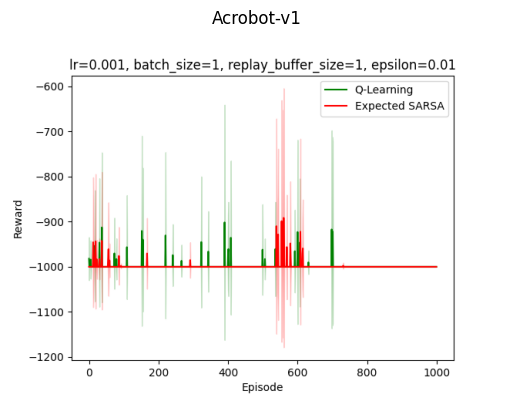

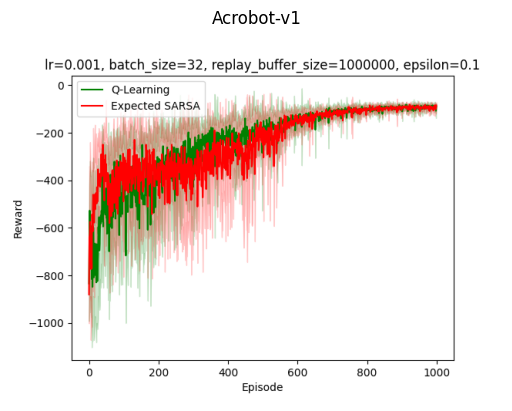

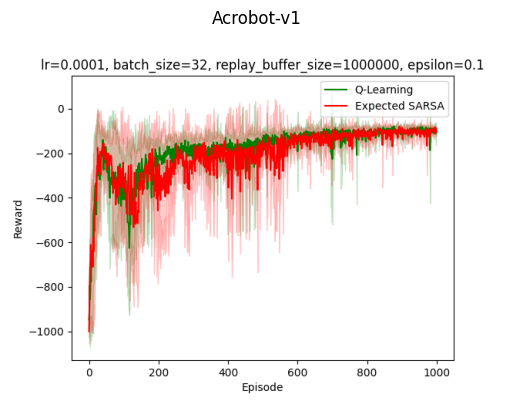

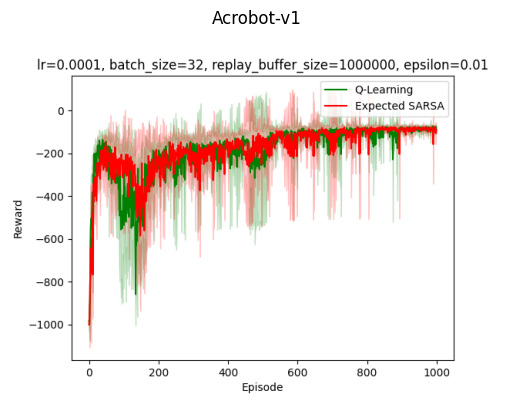

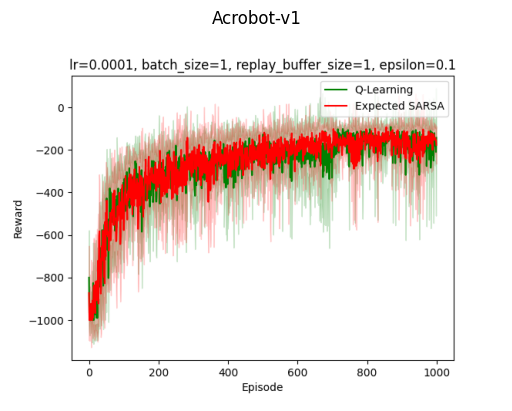

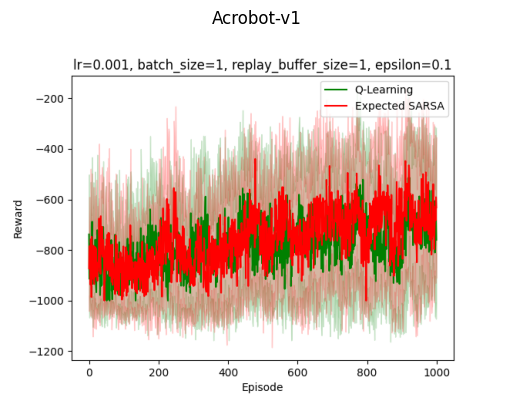

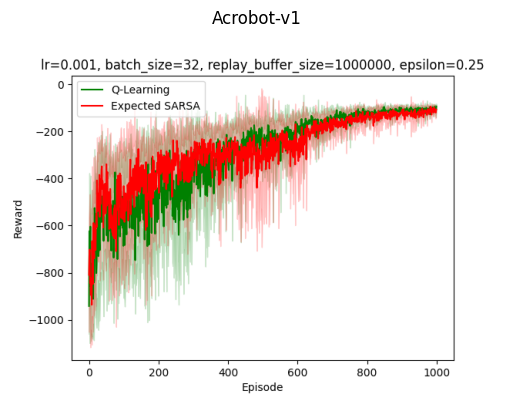

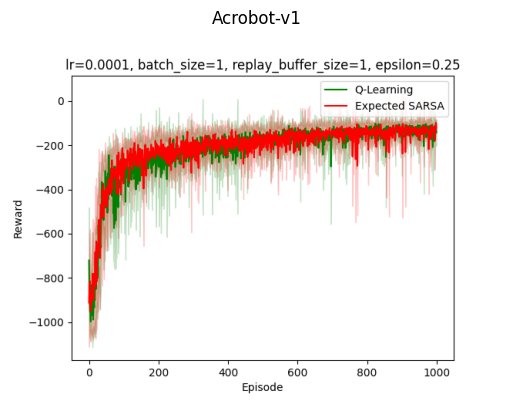

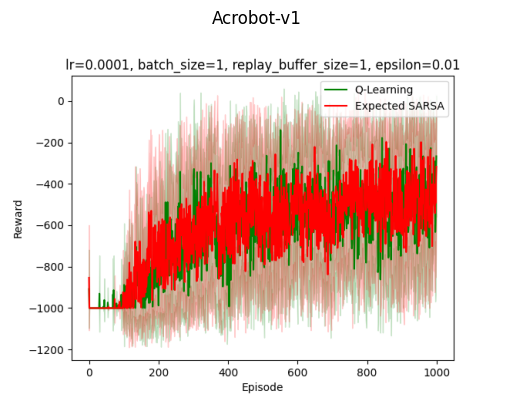

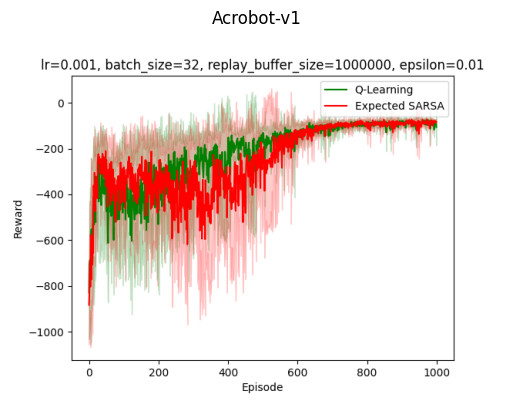

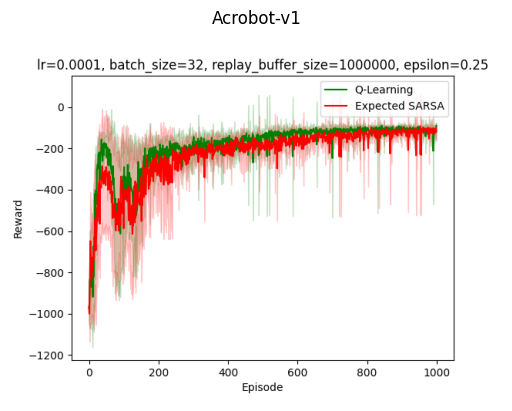

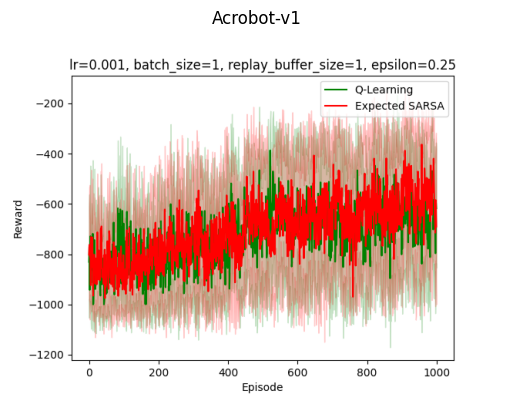

In [13]:
# get all files starting with plot 7 and display the pngs without having a double graph
for file in os.listdir():
    if file.startswith('plot_10'):
        img = plt.imread(file)
        plt.imshow(img)
        plt.title("Acrobot-v1")
        plt.axis('off')
        plt.show()

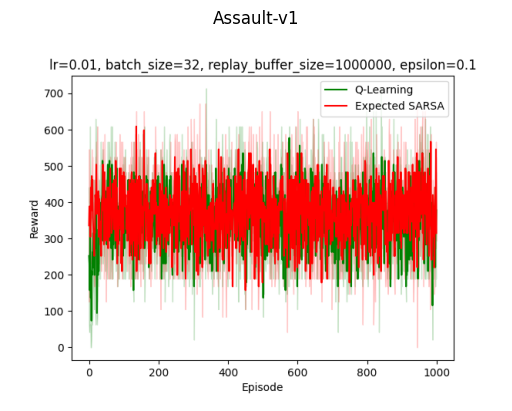

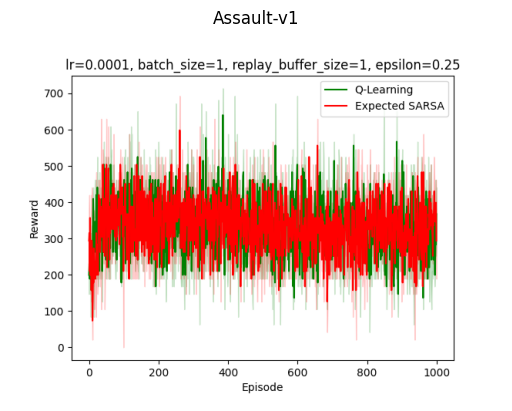

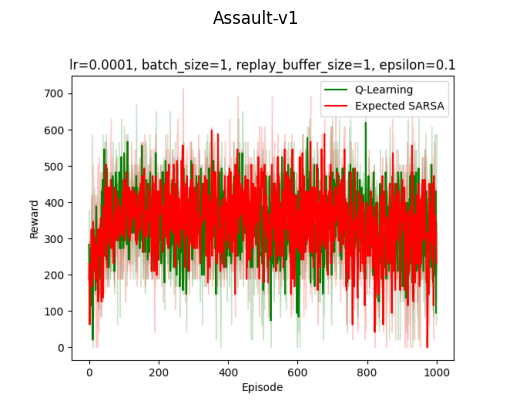

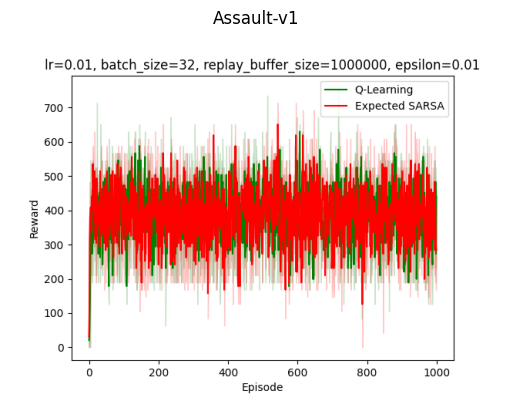

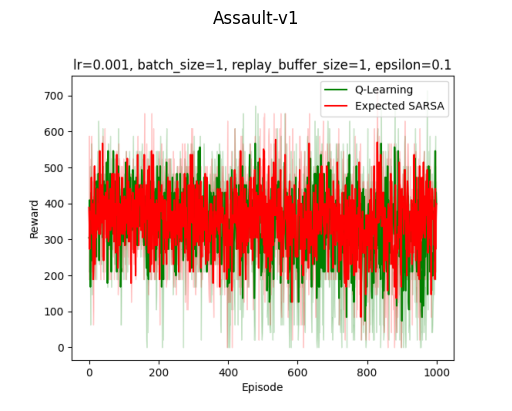

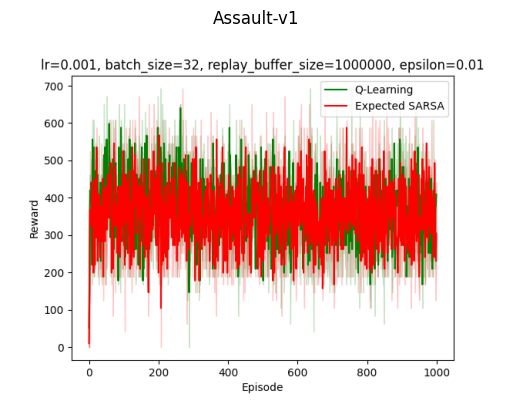

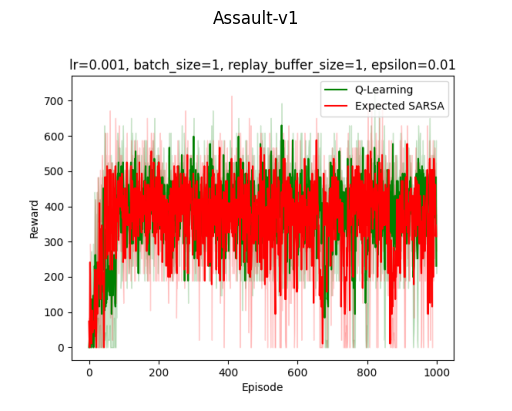

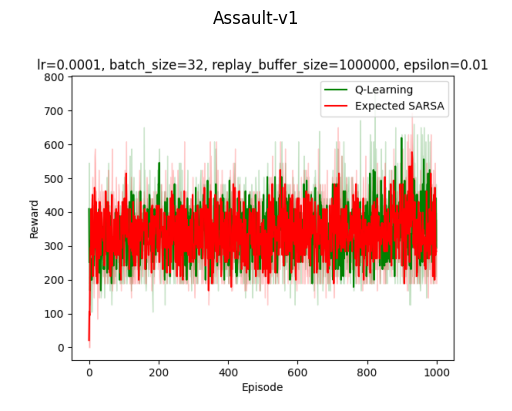

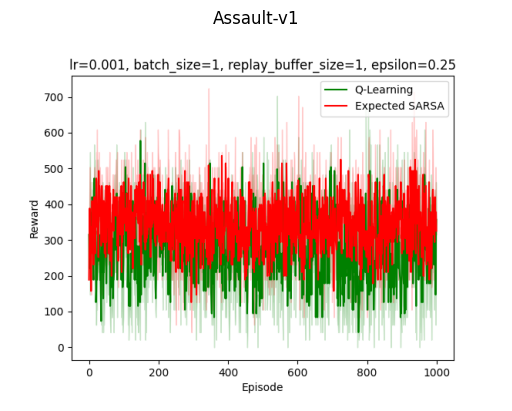

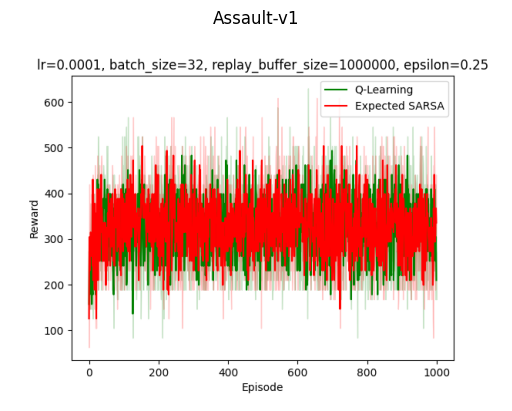

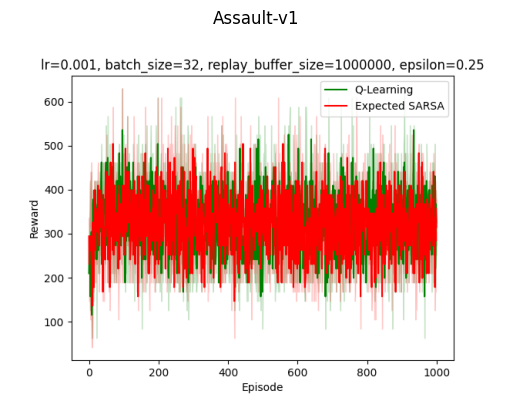

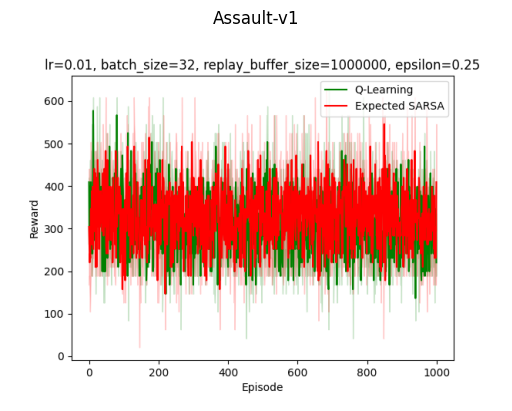

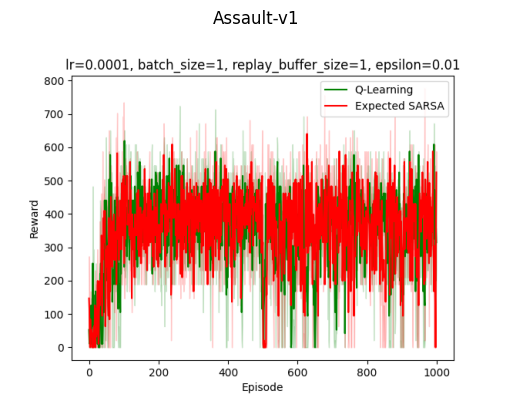

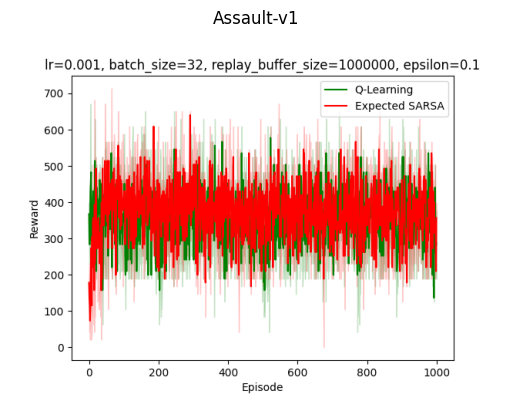

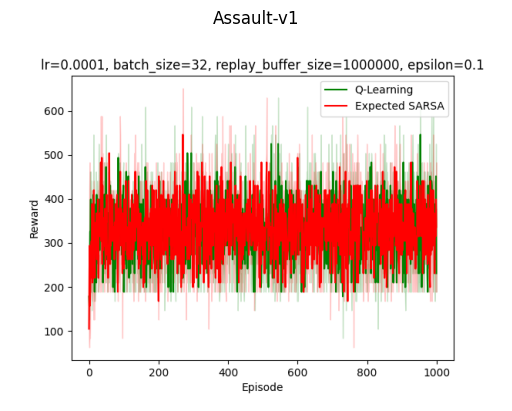

In [ ]:
# Do same as above but get files in acrobot target folder
for file in os.listdir('plots/Picklefiles/Acrobottarget'):
    if file.startswith('plot_10'):
        img = plt.imread('plots/Picklefiles/Acrobottarget/' + file)
        plt.imshow(img)
        plt.title("Assault-v1")
        plt.axis('off')
        plt.show()

Analysis:

QUESTION 2

ATTACHED PICTURE

Question 3:

In [ ]:
def BoltzmanPolicy(preds, temp):
    probs = torch.softmax(preds / temp, dim=1)
    a = torch.distributions.Categorical(probs).sample().item()
    return a, probs[0][a]

In [ ]:
def A2C(episodes, gamma, policy_lr,value_lr, T, decay, decay_rate, end_temp):
    policy_network = QNetwork(state_dim, action_dim)
    value_network = QNetwork(state_dim, 1)
    optimizer_actor = optim.Adam(policy_network.parameters(), lr=policy_lr)
    optimizer_value = optim.Adam(value_network.parameters(), lr=value_lr)
    rewards = []
    temp = T
    end_temp = end_temp
    for i in range(episodes):
        if decay:
            temp = T - ((T - end_temp) * i / episodes)
        total_reward = 0
        if i % 100 == 0:
            print("EPISODE#", i)
        state, info = env.reset()
        done = False
        step = 0
        policy_loss = 0
        value_loss = 0
        while not done  and step < 1000:
            with torch.no_grad():
                action, prob = BoltzmanPolicy(policy_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)), temp)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done:
                advantage = reward - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).detach()
            else:
                advantage = reward + gamma * value_network(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)).detach() - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).detach()
            preds = policy_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))[0]
            policy_loss -= torch.log(torch.exp(preds[action]/T)/torch.sum(torch.exp(preds/T))) * advantage
            value_loss +=  0.5*(reward + gamma * value_network(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)).detach() - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)))**2
            state = next_state
            step += 1
        mean_policy_loss = policy_loss / step
        mean_value_loss = value_loss / step
        optimizer_actor.zero_grad()
        optimizer_value.zero_grad()
        mean_policy_loss.backward()
        mean_value_loss.backward()
        optimizer_actor.step()
        optimizer_value.step()
        rewards.append(total_reward)
    return rewards

In [ ]:
def reinforce(episodes, lr, gamma, T, decay, decay_rate, end_temp):
    rewards = []
    q_network = QNetwork(state_dim, action_dim)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    temp = T
    end_temp = end_temp
    for i in range(episodes):
        if decay:
            temp = T - ((T - end_temp) * i / episodes)
        total_reward = 0
        if i % 100 == 0:
            print("EPISODE#", i)
        ep = []
        state, info = env.reset()
        done = False
        step = 0
        while not done and step < 1000:
            action, prob = BoltzmanPolicy(q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)), temp)
            next_state, reward, done, truncated, _= env.step(action)
            total_reward += reward
            ep.append((state, action, reward, prob))
            state = next_state
            step += 1
        grad = 0
        for t in range(len(ep)):
            G = sum([gamma**(i-t-1) * ep[i][2] for i in range(t, len(ep))])
            # print(G)
            grad += (gamma**t) * G * torch.log(max(prob,torch.tensor(1e-8)))
        optimizer.zero_grad()
        grad.backward()
        optimizer.step()
        rewards.append(total_reward)
    return rewards

In [ ]:
def run_experiment2(lr, T, decay, decay_rate, gamma, episodes, seeds):
    random_seeds = np.random.randint(0, 50, size=seeds)
    a2c_learning_rewards = np.zeros((seeds, EPISODES))
    reinforce_rewards = np.zeros((seeds, EPISODES))
    seeds = 10
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        torch.manual_seed(i)
        np.random.seed(i)
        a2c_learning_rewards[i] = A2C(episodes=episodes, gamma=gamma, policy_lr=lr, value_lr=lr, T=T, decay=decay, decay_rate=decay_rate, end_temp=decay_rate)
        reinforce_rewards[i] = reinforce(episodes=episodes, lr=lr, gamma=gamma, T=T, decay=decay, decay_rate=decay_rate, end_temp=decay_rate)
        pickle.dump(a2c_learning_rewards[i], open(f'RUN#{i}_ACROBOT_a2c_learning_rewards_{lr}_{T}_{decay}_{decay_rate}.pkl', 'wb'))
        pickle.dump(reinforce_rewards[i], open(f'RUN#{i}_ACROBOT_reinforce_rewards_{lr}_{T}_{decay}_{decay_rate}.pkl', 'wb'))
    a2c_learning_rewards_mean = a2c_learning_rewards.mean(axis=0)
    a2c_learning_rewards_std = a2c_learning_rewards.std(axis=0)/math.sqrt(seeds)
    reinforce_rewards_mean = reinforce_rewards.mean(axis=0)
    reinforce_rewards_std = reinforce_rewards.std(axis=0)/math.sqrt(seeds)
    plt.plot(a2c_learning_rewards_mean, label='A2C', color='green')
    plt.fill_between(range(EPISODES), a2c_learning_rewards_mean - a2c_learning_rewards_std, a2c_learning_rewards_mean + a2c_learning_rewards_std, color='green', alpha=0.2)
    plt.plot(reinforce_rewards_mean, label='Reinforce', color='red')
    plt.fill_between(range(EPISODES), reinforce_rewards_mean - reinforce_rewards_std, reinforce_rewards_mean + reinforce_rewards_std, color='red', alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig('plot.png')
    plt.show()

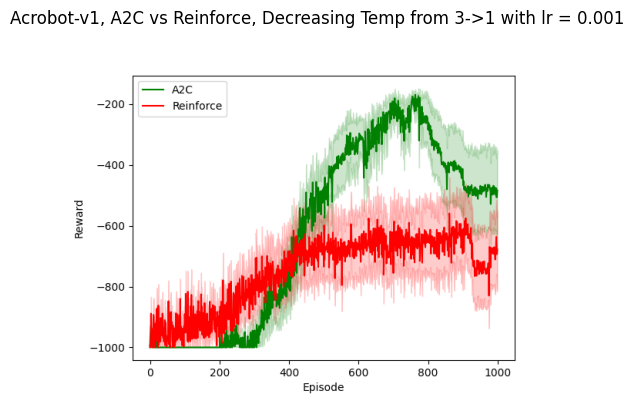

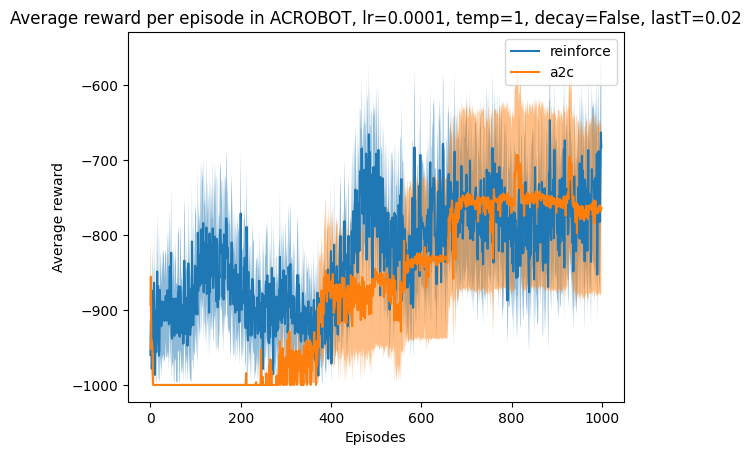

In [21]:
# Do same as above but get files 
file = 'plots/Q3/rawraw/plot.png'
img = plt.imread(file)
plt.imshow(img)
plt.title("Acrobot-v1, A2C vs Reinforce, Decreasing Temp from 3->1 with lr = 0.001")
plt.axis('off')
plt.show()
rew_combr = []
rew_combs = []
for i in range(10):
    fpath = f"plots/Q3/ACROBOT/RUN#{i}_ACROBOT_reinforce_rewards_0.0001_1_False_0.02.pkl"
    spath = f"plots/Q3/ACROBOT/RUN#{i}_ACROBOT_a2c_learning_rewards_0.0001_1_False_0.02.pkl"
    with open(fpath, "rb") as f:
        data = pickle.load(f)
        rew_combr.append(data)
    with open(spath, "rb") as f:
        data = pickle.load(f)
        rew_combs.append(data)


rew_combr = np.array(rew_combr)
mean_rewards = np.mean(rew_combr, axis=0)
std_rewards = np.std(rew_combr, axis=0)/np.sqrt(rew_combr.shape[0])
plt.plot(mean_rewards, label=f"reinforce")
plt.fill_between(range(mean_rewards.shape[0]), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.5)
rew_combs = np.array(rew_combs)
mean_rewards = np.mean(rew_combs, axis=0)
std_rewards = np.std(rew_combs, axis=0)/np.sqrt(rew_combs.shape[0])
plt.plot(mean_rewards, label=f"a2c")
plt.fill_between(range(mean_rewards.shape[0]), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.5)
plt.title(f"Average reward per episode in ACROBOT, lr=0.0001, temp=1, decay=False, lastT=0.02")
plt.xlabel("Episodes")
plt.ylabel("Average reward")
plt.legend()
plt.show()

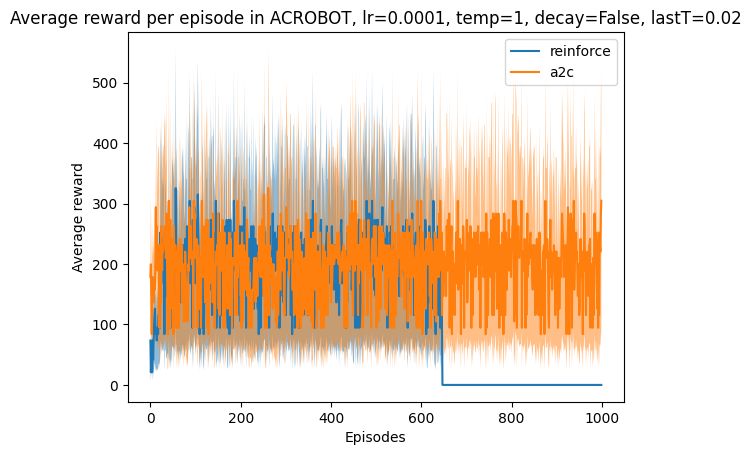

In [ ]:

rew_combr = []
rew_combs = []
for i in range(2):
    # fpath = f"RUN#{i}_ASSOT_reinforce_rewards_0.0001_2_False_1.pkl"
    # spath = f"RUN#{i}_ASST_a2c_learning_rewards_0.0001_2_False_1.pkl"
    fpath = f"RUN#{i}_ACROBOT_a2c_learning_rewards_0.0003_3_True_1.pkl"
    spath = f"RUN#{i}_ACROBOT_reinforce_rewards_0.0003_3_True_1.pkl"
    with open(fpath, "rb") as f:
        data = pickle.load(f)
        rew_combr.append(data)
    with open(spath, "rb") as f:
        data = pickle.load(f)
        rew_combs.append(data)


rew_combr = np.array(rew_combr)
mean_rewards = np.mean(rew_combr, axis=0)
std_rewards = np.std(rew_combr, axis=0)/np.sqrt(rew_combr.shape[0])
plt.plot(mean_rewards, label=f"reinforce")
plt.fill_between(range(mean_rewards.shape[0]), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.5)
rew_combs = np.array(rew_combs)
mean_rewards = np.mean(rew_combs, axis=0)
std_rewards = np.std(rew_combs, axis=0)/np.sqrt(rew_combs.shape[0])
plt.plot(mean_rewards, label=f"a2c")
plt.fill_between(range(mean_rewards.shape[0]), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.5)
plt.title(f"Average reward per episode in ASSAULT, lr=0.0001, temp=1, decay=False, lastT=0.02")
plt.xlabel("Episodes")
plt.ylabel("Average reward")
plt.legend()
plt.show()